In [1]:
import io
from collections import Counter

import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import pandas as pd
import plotly.graph_objects as go
from pygtrie import CharTrie
from pygtrie import ShortKeyError
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split

from retrain_bert import settings
from retrain_bert.inference import categories_to_ids_table, chunk_it, InferenceModel

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/julius/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
classified_ocr = pd.read_csv(settings.PROJECT_DIR / 'data/raw/classified_ocr.csv', dtype={"Category_BERT": str, "Category_MasterProduct": str})

In [3]:
classified_ocr.head()

,MappingGroupId,OcrValueId,OcrValue,ReceiptCount,Language,Category_BERT,VerifiedAt,BarcodeRequestId,ProductId,Category_MasterProduct,Brand
0,56,72911,PATATA ROJA,1038,es,0206020501,2021-12-14,2460,316654,02060205,NaN
1,56,72911,PATATA ROJA,1038,es,0206020501,2021-12-14,29634,316654,02060205,NaN
2,56,730245,CRISPY CHICKEN,176,es,0202,2021-12-14,7155,316646,02040504,NaN
3,56,730245,CRISPY CHICKEN,176,es,0202,2021-12-14,170356,316646,02040504,NaN
4,56,45025,LOMO IBÉRICO ADOB,222,es,020102,2021-12-14,2873,316640,02010203,NaN


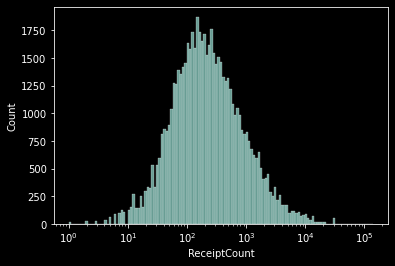

In [4]:
sns.histplot(data=classified_ocr, x=classified_ocr.ReceiptCount + 1, log_scale=True)
#plt.xscale('log')
plt.show()

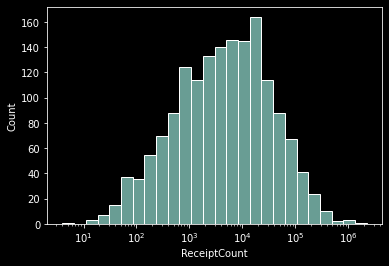

In [5]:
by_category = classified_ocr.groupby('Category_MasterProduct')['ReceiptCount'].sum()
sns.histplot(data=by_category, log_scale=(True, False))#, x="ReceiptCount")
#plt.xscale('log')
plt.show()

In [6]:
classified_ocr.Category_MasterProduct.unique().shape

(1629,)

In [7]:
(by_category > 100).sum()

1552

<AxesSubplot:xlabel='OcrValue', ylabel='Count'>

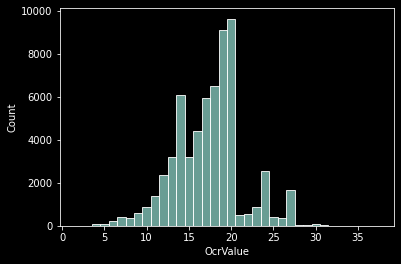

In [8]:
sns.histplot(x=classified_ocr.OcrValue.str.len(), discrete=True)

<AxesSubplot:xlabel='OcrValue', ylabel='Count'>

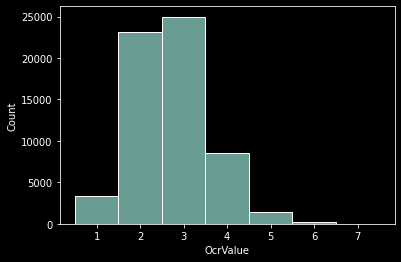

In [9]:
sns.histplot(x=classified_ocr.OcrValue.str.split().str.len(), discrete=True)

In [10]:
word_counts = Counter()
for ocr_value in classified_ocr.OcrValue:
    word_counts.update(ocr_value.strip().split())
word_counts.most_common(40)

[('DE', 2222),
 ('LECHE', 1764),
 ('AGUA', 1235),
 ('1L', 1169),
 ('QUESO', 1063),
 ('PAN', 930),
 ('ZERO', 921),
 ('COLA', 905),
 ('G', 758),
 ('DIA', 735),
 ('NARANJA', 697),
 ('L', 692),
 ('POLLO', 667),
 ('1', 656),
 ('TOMATE', 648),
 ('ALIPENDE', 647),
 ('GALLETA', 619),
 ('CHOCO', 590),
 ('BEBIDA', 553),
 ('NATURAL', 544),
 ('LA', 535),
 ('YOGUR', 534),
 ('SEMI', 520),
 ('MINI', 506),
 ('PIZZA', 505),
 ('LIMON', 504),
 ('CONSUM', 487),
 ('CHOCOLATE', 485),
 ('ZUMO', 475),
 ('FRESA', 474),
 ('CON', 472),
 ('2', 468),
 ('ARROZ', 467),
 ('CERVEZA', 450),
 ('SIN', 441),
 ('NATA', 435),
 ('CREMA', 431),
 ('LATA', 413),
 ('1,5L', 409),
 ('COCA', 406)]

In [11]:
stopwords = nltk.corpus.stopwords.words('spanish')

def most_common_ngrams(corpus, n=2, ignore=stopwords):
    count_vect = CountVectorizer(ngram_range=(n, n), stop_words=ignore)
    count_vect.fit(io.StringIO(corpus))
    freqs = count_vect.transform(io.StringIO(corpus))
    freqs = freqs.sum(axis=0)
    # countvectorizer doesn't seem to give predictable order
    words_list = [word for word in count_vect.vocabulary_.keys()]
    freq_list = [freqs[0, idx] for idx in count_vect.vocabulary_.values()]
    words_freq = pd.Series(index=words_list, data=freq_list)
    return words_freq.sort_values(ascending=False)

In [12]:
f = most_common_ngrams(classified_ocr.OcrValue.str.cat(sep='\n'), n=1)
f

leche      2158
agua       1327
1l         1307
queso      1272
cola       1233
           ... 
muralla       1
110ml         1
laise         1
burr          1
tomt          1
Length: 13215, dtype: int64

In [13]:
classified_ocr.MappingGroupId.unique().shape

(20,)

In [14]:
classified_ocr

,MappingGroupId,OcrValueId,OcrValue,ReceiptCount,Language,Category_BERT,VerifiedAt,BarcodeRequestId,ProductId,Category_MasterProduct,Brand
0,56,72911,PATATA ROJA,1038,es,0206020501,2021-12-14,2460,316654,02060205,NaN
1,56,72911,PATATA ROJA,1038,es,0206020501,2021-12-14,29634,316654,02060205,NaN
2,56,730245,CRISPY CHICKEN,176,es,0202,2021-12-14,7155,316646,02040504,NaN
3,56,730245,CRISPY CHICKEN,176,es,0202,2021-12-14,170356,316646,02040504,NaN
4,56,45025,LOMO IBÉRICO ADOB,222,es,020102,2021-12-14,2873,316640,02010203,NaN
...,...,...,...,...,...,...,...,...,...,...,...
61600,56,7123212,CAMPLLONG LECHE,21,es,01030101,2022-03-22,173084,347597,0103010103,Campllong
61601,56,7821681,AGROS LECHE ENTERA,12,es,0103010101,2022-05-12,242408,354527,0103010101,Agros
61602,56,7615157,AGROS DESNATADA,29,es,0103010102,2022-04-01,185939,347599,0103010102,Agros
61603,56,7615157,AGROS DESNATADA,29,es,0103010102,2022-04-01,269782,347599,0103010102,Agros


In [15]:
classified_ocr.drop_duplicates(subset=['OcrValueId', 'MappingGroupId', 'Category_MasterProduct'], inplace=True)
classified_ocr.shape

(40861, 11)

In [16]:
classified_ocr.Category_MasterProduct.isna().sum()

1338

In [17]:
classified_ocr.Category_BERT.isna().sum()

15

In [18]:
classified_ocr.dropna(subset=['Category_MasterProduct', 'Category_BERT'], inplace=True)
classified_ocr.shape

(39509, 11)

In [19]:
def chunk_string(string, chunk_size):
    return [string[i:i+chunk_size] for i in range(0, len(string), chunk_size)]

def split_into_categories(category_code, num_categories=5):
    categories = chunk_string(category_code, 2)
    categories += [None] * (num_categories - len(categories))
    if len(categories) != num_categories:
        print(categories)
    return categories

In [20]:
split_into_categories("02060205")

['02', '06', '02', '05', None]

In [21]:
sankey_values = []
for idx, row in classified_ocr.iterrows():
    categories = split_into_categories(row.Category_MasterProduct)
    sankey_values.append(
        {
            "target": row.Category_MasterProduct,
            "source": row.Category_MasterProduct[:-2],
        }
    )
sankey_df = pd.DataFrame(sankey_values)
sankey_df["value"] = 1
sankey_df = sankey_df.groupby(["source", "target"]).count().reset_index()


print("Sankey description:")
print(sankey_df.describe())


sankey_df = sankey_df.sort_values(by=["source", "target"]).reset_index(drop=True)

# add missing sources
missing_sources = set(sankey_df.source) - set(sankey_df.target)
while len(missing_sources) > 1:
    # start by filling in most specific categories
    missing_sources = sorted(missing_sources, key=len, reverse=True)
    missing_sankeys = []
    for source in missing_sources:
        loc = sankey_df.source == source
        missing_sankeys.append(
            # we'll add downsteam values later
            {"source": source[:-2], "target": source, "value": 0}
        )
    sankey_df = pd.concat([sankey_df, pd.DataFrame(missing_sankeys)])
    missing_sources = set(sankey_df.source) - set(sankey_df.target)


sankey_df = sankey_df.sort_values(by=["source", "target"]).reset_index(drop=True)

# add downstream values
for row in sankey_df[::-1].itertuples(index=True):
    idx = row.Index
    while idx < len(sankey_df) and sankey_df.loc[idx, "source"] != row.target:
        idx += 1
    if idx < len(sankey_df):
        summed_values = sankey_df.loc[idx, "value"]
        while idx < len(sankey_df) and sankey_df.loc[idx, "source"] == row.target:
            summed_values += sankey_df.loc[idx, "value"]
            idx += 1
        sankey_df.loc[row.Index, "value"] += summed_values

if sankey_df.loc[0, "source"] == sankey_df.loc[0, "target"]:
    sankey_df = sankey_df.loc[1:]


sankey_df

Sankey description:
             value
count  1628.000000
mean     24.268428
std      42.094734
min       1.000000
25%       4.000000
50%      10.000000
75%      28.000000
max     696.000000


,source,target,value
1,,01,61719
2,,02,28200
3,,03,10341
4,,04,1660
5,01,0101,19167
...,...,...,...
1709,04081603,0408160302,4
1710,04081603,0408160306,7
1711,0409,040917,332
1712,040917,04091701,166


In [22]:
def parent_categories(category_code):
    for i in range(len(category_code) // 2):
        yield category_code[:-2*i]

labels = set(classified_ocr.Category_MasterProduct.unique())
for cat in classified_ocr.Category_MasterProduct.unique():
    labels = labels.union(parent_categories(cat))
labels = sorted(labels)
labels_table = {l: idx for idx, l in enumerate(labels)}

In [23]:
use_for_plot = sankey_df[sankey_df.target.str.len() < 8]

print(len(use_for_plot))

sources = [labels_table[s] for s in use_for_plot.source]
targets = [labels_table[t] for t in use_for_plot.target]

188


In [24]:
node = go.sankey.Node(label=labels)
link = go.sankey.Link(source=sources, target=targets, value=use_for_plot.value)

fig = go.Figure(data=go.Sankey(node=node, link=link, orientation="v"))

fig.show()

In [25]:
unique_nodes = CharTrie((v, True) for v in sankey_df[sankey_df.target.str.len() == 5 * 2].target.values)
len(unique_nodes)

861

In [26]:
for target in sankey_df.target:
    try:
        unique_nodes[target]
    except ShortKeyError:
        continue
    except KeyError:
        unique_nodes[target] = True

In [27]:
len(unique_nodes)

1256

In [28]:
cats = classified_ocr.Category_MasterProduct.apply(lambda x: split_into_categories(x))
cats_df = pd.DataFrame.from_records(cats.values)
cats_df.columns = [f"level_{i}" for i in range(1, 6)]

cats_sankey_values = []
for target in cats_df["level_1"].unique():
    value = cats_df[cats_df[f"level_1"] == target].shape[0]
    cats_sankey_values.append({"level": 1, "source": "00", "target": target, "value": value})
for level in range(2, 6):
    for target in cats_df[f"level_{level}"].unique():
        for source in cats_df[f"level_{level - 1}"].unique():
            value = cats_df[(cats_df[f"level_{level - 1}"] == source) & (cats_df[f"level_{level}"] == target)].shape[0]
            cats_sankey_values.append({
                "level": level,
                "source": source,
                "target": target,
                "value": value
            })
cats_sankey_df = pd.DataFrame(cats_sankey_values)
cats_sankey_df = cats_sankey_df[cats_sankey_df.value > 0]
cats_sankey_df.shape

(438, 4)

In [29]:
cats_labels = [f"l{l}_{t}" for l in cats_sankey_df.level.unique() for t in cats_sankey_df.target.unique()]
cats_labels += ["l1_00", ]

cats_labels = sorted(cats_labels)
cats_labels_table = {l: idx for idx, l in enumerate(cats_labels)}

In [30]:
cats_sankey_df.sort_values(["level", "source"])

,level,source,target,value
0,1,00,02,13883
1,1,00,01,20960
2,1,00,03,4195
3,1,00,04,471
9,2,01,04,5588
...,...,...,...,...
1307,5,13,03,3
1338,5,13,02,32
1369,5,13,05,47
1524,5,13,04,105


In [31]:
classified_ocr

,MappingGroupId,OcrValueId,OcrValue,ReceiptCount,Language,Category_BERT,VerifiedAt,BarcodeRequestId,ProductId,Category_MasterProduct,Brand
0,56,72911,PATATA ROJA,1038,es,0206020501,2021-12-14,2460,316654,02060205,NaN
2,56,730245,CRISPY CHICKEN,176,es,0202,2021-12-14,7155,316646,02040504,NaN
4,56,45025,LOMO IBÉRICO ADOB,222,es,020102,2021-12-14,2873,316640,02010203,NaN
5,16,5510,TOMATE RAMA CARREF,2580,es,0206020301,2021-12-14,28555,238222,0206020301,NaN
6,29,74990,TOMAQUET BRANCA,298,ca,0206020301,2022-01-05,100501,238222,0206020301,NaN
...,...,...,...,...,...,...,...,...,...,...,...
61598,56,8752259,GAREA LECHE SEMI,50,es,0103010103,2022-05-25,223289,354520,0103010103,Garea
61599,56,7123212,CAMPLLONG LECHE,21,es,01030101,2022-03-22,204115,354518,0103010101,Campllong
61600,56,7123212,CAMPLLONG LECHE,21,es,01030101,2022-03-22,173084,347597,0103010103,Campllong
61601,56,7821681,AGROS LECHE ENTERA,12,es,0103010101,2022-05-12,242408,354527,0103010101,Agros


In [32]:
classified_ocr["Category_BERT_Truncated"] = classified_ocr.apply(
    lambda row: row.Category_BERT[:len(row.Category_MasterProduct)], axis="columns"
)

In [33]:
classified_ocr["Category_match"] = classified_ocr.Category_BERT_Truncated == classified_ocr.Category_MasterProduct 
acc = classified_ocr.Category_match.mean()
macro_acc = classified_ocr[["MappingGroupId", "Category_match"]
    ].groupby(["MappingGroupId"]
    ).agg({"Category_match": "mean"}
    ).mean().Category_match

print(f"Headline accuracy: {acc:.2f}, retailer-macro accuracy: {macro_acc:.2f}")

Headline accuracy: 0.20, retailer-macro accuracy: 0.22


In [34]:
def level_specific_accuracy(classified_ocr, level):
    bert_pred = classified_ocr.Category_BERT_Truncated.str[:level * 2]
    master_pred = classified_ocr.Category_MasterProduct.str[:level * 2]
    return (bert_pred == master_pred).mean()

print("Average across retailers:")
for level in range(1, 6):
   print(f"Level {level} acc: {level_specific_accuracy(classified_ocr, level):.2f}")

Average across retailers:
Level 1 acc: 0.90
Level 2 acc: 0.84
Level 3 acc: 0.75
Level 4 acc: 0.28
Level 5 acc: 0.20


In [35]:
def level_specific_accuracy(classified_ocr, level):
    bert_pred = classified_ocr.Category_BERT_Truncated.str[:level * 2]
    master_pred = classified_ocr.Category_MasterProduct.str[:level * 2]
    return f1_score(bert_pred, master_pred, average="macro")

print("Average across retailers:")
for level in range(1, 6):
   print(f"Level {level} f1: {level_specific_accuracy(classified_ocr, level):.2f}")

Average across retailers:
Level 1 f1: 0.80
Level 2 f1: 0.62
Level 3 f1: 0.55
Level 4 f1: 0.13
Level 5 f1: 0.10


In [36]:
for lang, group in classified_ocr.groupby("Language"):
    accs = [level_specific_accuracy(group, level).round(2) for level in range(1, 6)]
    print(f"{lang}: {accs}")

ca: [0.62, 0.42, 0.37, 0.11, 0.09]
es: [0.85, 0.66, 0.57, 0.13, 0.1]


In [37]:
for mapping_group_id, group in classified_ocr.groupby("MappingGroupId"):
    accs = [level_specific_accuracy(group, level) for level in range(1, 6)]
    print(f"{mapping_group_id}: {accs}")

1: [0.9395996643976096, 0.8148252591807756, 0.722513013349901, 0.16517189884425326, 0.15735860959167064]
2: [0.7937666168924982, 0.7373128018480981, 0.6043213263293417, 0.13199806581482218, 0.1392422323788131]
3: [0.8634420188742005, 0.6721202105109959, 0.6541380909499336, 0.18920112628587407, 0.19654940999047413]
4: [0.739275179098188, 0.5985285811631996, 0.6665697897061995, 0.175310549239744, 0.1272406605739939]
13: [0.4414404809686267, 0.28686009112838373, 0.24319861173309448, 0.0943667098946602, 0.056672599819807934]
15: [0.5343533697632058, 0.34284016636957815, 0.2943287037037037, 0.08436213991769546, 0.03951890034364261]
16: [0.8496193570717839, 0.7316576108541476, 0.5864990374055358, 0.12590483943556866, 0.10292644571543277]
28: [0.5084415584415584, 0.37754227196951656, 0.35413178091749525, 0.12132505175983437, 0.07688679245283017]
29: [0.7416966991578201, 0.5263500108090254, 0.5209597277158416, 0.1374199332902931, 0.13755657428396806]
34: [0.797339922833485, 0.6632864949676053,

In [38]:
classified_ocr[classified_ocr.MappingGroupId == 13].shape

(178, 13)

In [39]:
classified_ocr[classified_ocr.MappingGroupId == 15].shape

(75, 13)

In [40]:
classified_ocr[classified_ocr.MappingGroupId == 28].shape

(92, 13)

In [41]:
classified_ocr[classified_ocr.MappingGroupId == 62].shape

(13708, 13)

In [42]:
classified_ocr[classified_ocr.MappingGroupId == 69].shape

(67, 13)

In [43]:
classified_ocr[classified_ocr.MappingGroupId == 59].shape

(4, 13)

In [44]:
train, val = train_test_split(classified_ocr, random_state=42)

In [45]:
model = InferenceModel()

new_val_cats = []
for batch in chunk_it(val.OcrValue, 64):
    new_val_cats.extend(model.infer(batch))

2022-09-08 15:36:12.909473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:36:13.391683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:36:13.392509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:36:13.395457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [46]:
val["Category_new"] = new_val_cats

In [47]:
(val["Category_BERT"] == val["Category_new"]).mean()

0.15863535128568537

In [48]:
(val["Category_MasterProduct"] == val["Category_new"]).mean()

0.589289329823851

In [49]:
def exact_category_accuracy(pred_cat_str, true_cat_str, level):
    # making copies since I'm later modifying them in-place
    pred_cat_str = list(pred_cat_str)
    true_cat_str = list(true_cat_str)
    for idx, (pred_cat, true_cat) in enumerate(zip(pred_cat_str, true_cat_str)):
        true_cat = true_cat[:2*level]
        pred_cat = pred_cat[:len(true_cat)]
        pred_cat_str[idx] = pred_cat
        true_cat_str[idx] = true_cat
    return sum(pred == true for pred, true in zip(pred_cat_str, true_cat_str)) / len(pred_cat_str)

[round(exact_category_accuracy(val.Category_new, val.Category_MasterProduct, level), 2) for level in range(1, 6)]

[0.97, 0.93, 0.86, 0.74, 0.68]

In [50]:
model.predict("P.MOLDE 100% INT")

['0101140102']